# Likert scale analysis

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1cfmngp/q_likert_scale_analysis_first_time/).

> I have collected data regarding how individuals feel about a particular program. They reported their feelings on a scale of 1-5, with 1 being Strongly Disagree, 2 being Disagree, 3 being Neutral, 4 being Agree, and 5 being Strongly Agree.
>
> I am looking to analyze the data for averages responses, but I see that a basic mean will not do the trick. I am looking for very simple statistical analysis on the data. Could someone help out regarding what I would do?

It sounds like OP has heard the advice that you should not compute the mean of values on a Likert scale.
The Likert scale is ordinal, which means that the values are ordered, but it is not an interval scale, because the distances between successive points are not necessarily equal.

For example, if we imagine that "Neutral" maps to 0 on a number line and "Agree" maps to 1, it's not clear where we should place "Strongly agree".
And an appropriate mapping might not be symmetric -- for example, maybe the people who choose "Strongly agree" are content, but the people who choose "Strongly disagree" are angry.
In an arithmetic mean, they would cancel each other out -- but that might erase an important distinction.

Nevertheless, I think an absolute prohibition on computing means is too strong.
I'll show some examples where I think it's a reasonable thing to do -- but I'll also suggest alternatives that might be better.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/likert_mean.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

In [2]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

## Political views

As an example, I'll use data from the General Social Survey (GSS), which I have resampled to correct for stratified sampling.

In [3]:
download('https://github.com/AllenDowney/DataQnA/raw/main/data/gss_qna_extract.hdf')

'gss_qna_extract.hdf'

In [4]:
gss = pd.read_hdf('gss_qna_extract.hdf', 'gss')

The variable we'll start with is `polviews`, which contains responses to this question:

>We hear a lot of talk these days about liberals and conservatives. I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

This is not a Likert scale, specifically, but it is ordinal.
Here is the distribution of responses:

In [5]:
from utils import values

values(gss['polviews'])

polviews
1.0     2095
2.0     7309
3.0     7799
4.0    24157
5.0     9816
6.0     9612
7.0     2145
NaN     9457
Name: count, dtype: int64

Here's the mapping from numerical values to the options that were shown to respondents.

In [6]:
polviews_dict = {
    1: "Extremely liberal",
    2: "Liberal",
    3: "Slightly liberal",
    4: "Moderate",
    5: "Slightly conservative",
    6: "Conservative",
    7: "Extremely conservative",
}

As always, it's a good idea to visualize the distribution before we compute any summary statistics.
I'll use `Pmf` from `empiricaldist` to compute the PMF of the values.

In [7]:
from empiricaldist import Pmf

pmf_polviews = Pmf.from_seq(gss['polviews'])

Here's what it looks like.

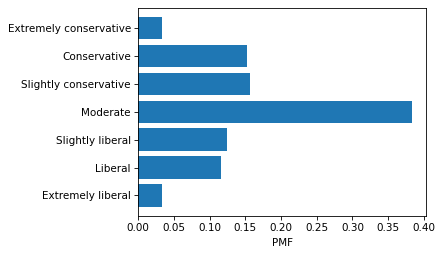

In [8]:
labels = list(polviews_dict.values())
plt.barh(labels, pmf_polviews)
decorate(xlabel='PMF')

The modal value is "Moderate" and the distribution is roughly symmetric, so I think it's reasonable to compute a mean.
For example, suppose we want to know how self-reported political alignment has changed over time.
We can compute the mean in each year like this:

In [9]:
mean_series = gss.groupby('year')['polviews'].mean()

And plot it like this.

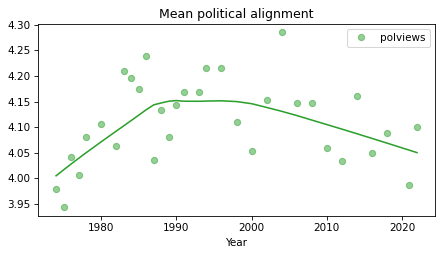

In [10]:
from utils import plot_series_lowess

plot_series_lowess(mean_series, 'C2')
decorate(xlabel='Year',
         title='Mean political alignment')

I used LOWESS to plot a local regression line, which makes long-term trends easier to see.
It looks like the center of mass trended toward conservative from the 1970s to 1990 and trended toward liberal since then.

When you compute any summary statistic, you lose information.
To see what we might be missing, we can use a normalized cross-tabulation to compute the distribution of responses in each year.

In [11]:
xtab = pd.crosstab(gss['year'], gss['polviews'], normalize='index')
xtab.head()

polviews,1.0,2.0,3.0,4.0,5.0,6.0,7.0
year,,,,,,,
1974,0.021908,0.142049,0.149117,0.380212,0.157597,0.127915,0.021201
1975,0.040057,0.131617,0.148069,0.386266,0.145923,0.115880,0.032189
1976,0.021877,0.139732,0.123500,0.398024,0.147495,0.145378,0.023994
1977,0.025085,0.122712,0.145085,0.402712,0.164746,0.111186,0.028475
1978,0.014463,0.096419,0.175620,0.384986,0.182507,0.128788,0.017218


And we can use a heat map to visualize the results.

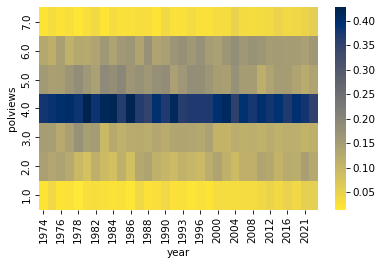

In [12]:
sns.heatmap(xtab.T, cmap='cividis_r')
plt.gca().invert_yaxis()

Based on the heat map, it seems like the general shape of the distribution has not changed over time, which means that the mean is probably a good way to make comparisons over time.

However, it is hard to interpret the mean in absolute terms.
For example, in the most recent data, the mean is about 4.1.

In [13]:
gss.query('year == 2022')['polviews'].mean()

4.099445902595509

Since 4.0 maps to "Moderate", we can say that the center of mass is slightly on the conservative side of moderate, but it's hard to say what a difference of 0.1 means on this scale.

As an alternative, we could add up the percentage who identify as conservative or liberal, with or without an adverb.

In [14]:
con = xtab[[5, 6, 7]].sum(axis=1) * 100
lib = xtab[[1, 2, 3]].sum(axis=1) * 100

And plot those percentages over time.

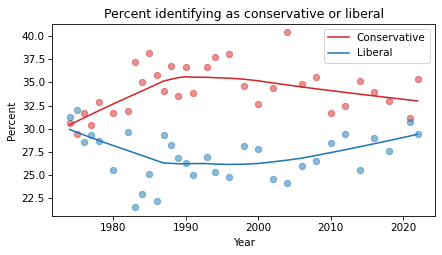

In [15]:
plot_series_lowess(con, 'C3', label='Conservative')
plot_series_lowess(lib, 'C0', label='Liberal')

decorate(xlabel='Year',
         ylabel='Percent',
         title='Percent identifying as conservative or liberal')

Or we could plot the difference in percentage points.

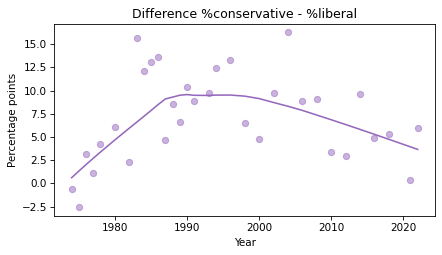

In [16]:
diff = con - lib
plot_series_lowess(diff, 'C4')

decorate(xlabel='Year',
         ylabel='Percentage points',
         title='Difference %conservative - %liberal')

This figure shows the same trends we saw by plotting the mean, but the y-axis is more interpretable -- for example, we could report that, at the peak of the Reagan era, conservatives outnumbered liberals by 10-15 percentage points.

## Standard deviation

Suppose we are interested in polarization, so we want to see if the spread of the distribution has changed over time.
Would it be OK to compute the standard deviation of the responses?
As with the mean, my answer is yes and no.

First, let's see what it looks like.

In [17]:
std_series = gss.groupby('year')['polviews'].std()

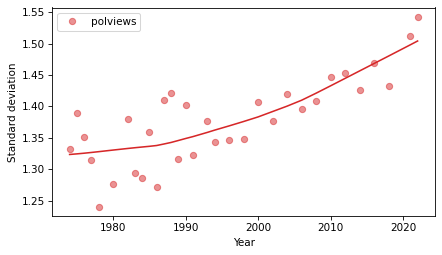

In [18]:
plot_series_lowess(std_series, 'C3')
decorate(xlabel='Year',
         ylabel='Standard deviation')

The standard deviation is easy to compute, and it makes it easy to see the long-term trend.
If we interpret the spread of the distribution as a measure of polarization, it looks like it has increased in the last 30 years.

But it is not easy to interpret this result in context.
It looks like it increased from about 1.35 to 1.5.
Is that a lot?
It's hard to say.

As an alternative, let's compute the mean absolute deviation (MAD), which we can think of like this: if we choose two people at random, how much will they differ on this scale, on average?

A quick way to estimate MAD is to draw two samples from the responses and compute the mean pairwise distance.

In [19]:
def sample_mad(series, size=1000):
    data = series.dropna()
    if len(data) == 0:
        return np.nan
    sample1 = np.random.choice(data, size=size, replace=True)
    sample2 = np.random.choice(data, size=size, replace=True)
    mad = np.abs(sample1 - sample2).mean()
    return mad

In [20]:
sample_mad(gss['polviews'])

1.537

The result is about 1.5 points, which is bigger than the distance from moderate to slightly conservative, and smaller than the distance from moderate to conservative.

Rather than sampling, we can compute the MAD deterministically by forming the joint distribution of response pairs and computing the expected value of the distances.
For this computation, it is convenient to use NumPy functions for outer product and outer difference.

In [21]:
def outer_mad(series):
    pmf = Pmf.from_seq(series)
    if len(pmf) == 0:
        return np.nan
    ps = np.outer(pmf, pmf)
    qs = np.abs(np.subtract.outer(pmf.index, pmf.index))
    return np.sum(ps * qs)

Again, the result is about 1.5 points.

In [22]:
outer_mad(gss['polviews'])

1.5360753915376488

Now we can see how this value has changed over time.

In [23]:
mad_series = gss.groupby('year')['polviews'].apply(outer_mad)

Here's the result, along with the standard deviation.

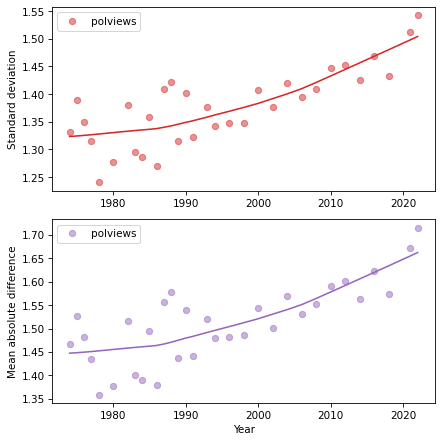

In [24]:
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plot_series_lowess(std_series, 'C3')
decorate(xlabel='',
         ylabel='Standard deviation')

plt.subplot(2, 1, 2)
plot_series_lowess(mad_series, 'C4')

decorate(xlabel='Year',
         ylabel='Mean absolute difference')

The two figures tell the same story -- polarization is increasing.
But the MAD is easier to interpret.
In the 1970s, if you chose two people at random, they would differ by less than 1.5 points on average.
Now the difference would be almost 1.7 points.
Considering that the difference between a moderate and a conservative is 2 points, it seems like we should still be able to get along.

I think MAD is more interpretable than standard deviation, but it is based on the same assumption that the points on the scale are equally spaced.
In most cases, that's not an assumption we can easily check, but in this example, maybe we can.

For another project, I selected 15 questions in the GSS where conservatives and liberals are most likely to disagree, and used them to estimate the number of conservative responses from each respondent.
The following figure shows the average number of conservative responses to the 15 questions for each point on the self-reported scale.

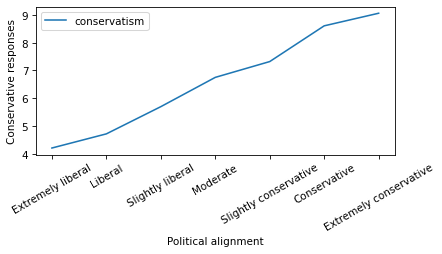

In [25]:
from utils import xticks

conservatism = gss.groupby('polviews')['conservatism'].mean()
conservatism.plot()
xticks(polviews_dict, rotation=30)
decorate(xlabel='Political alignment',
         ylabel='Conservative responses')

The result is close to a straight line, which suggests that the assumption of equal spacing is not bad in this case.

## When is the mean bad?

In the examples so far, computing the mean and standard deviation of a scale variable is not necessarily the best choice, but it could be a reasonable choice.
Now we'll see an example where it is probably a bad choice.

The variable `homosex` contains responses to this question:

> What about sexual relations between two adults of the same sex--do you think it is always wrong, almost always wrong, wrong only sometimes, or not wrong at all?

If the wording of the question seems loaded, remember that many of the core questions in the GSS were written in the 1970s.
Here is the encoding of the responses.

In [26]:
homosex_dict = {
    1: "Always wrong",
    2: "Almost always wrong",
    3: "Sometimes wrong",
    4: "Not wrong at all",
    5: "Other",
}

And here are the value counts.

In [27]:
values(gss['homosex'])

homosex
1.0    24856
2.0     1857
3.0     2909
4.0    12956
5.0       94
NaN    29718
Name: count, dtype: int64

Before we do anything else, let's look at the distribution of responses.

In [28]:
pmf_homosex = Pmf.from_seq(gss['homosex'])

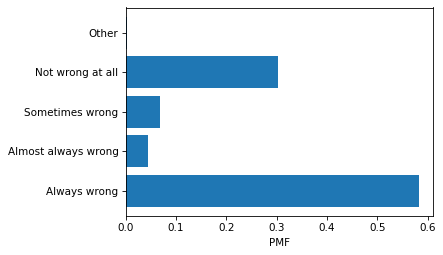

In [29]:
labels = list(homosex_dict.values())
plt.barh(labels, pmf_homosex)
decorate(xlabel='PMF')

In this example, there are several reasons it's a bad idea to summarize this distribution by computing the mean.
First, the "Other" response means that the values are not ordered.
So if we include this response in the mean, the result is meaningless.

In [30]:
gss['homosex'].mean()         # total nonsense

2.099526621672291

If we exclude "Other", the remaining responses are ordered, but arguably not evenly spaced on a spectrum of opinion.

In [31]:
gss['homosex'].replace(5, np.nan).mean()         # still nonsense

2.0931232091690544

If we compute a mean and report that the average response is somewhere between "Sometimes wrong" and "Almost always wrong", that is not an effective summary of the distribution.

The distribution of results is strongly bimodal -- most people are either accepting of homosexuality or not.
And that suggests a better way to summarize the distribution: we can simply report the fraction of respondents who choose one extreme or the other.

I'll start by creating a binary variable that is `1` for respondents who chose "Not wrong at all", `0` for the other responses, and `NaN` for people who were not asked the question or did not respond.

In [32]:
homosex_recode = {
    1: 0,
    2: 0,
    3: 0,
    4: 1,
    5: np.nan,
}

gss['homosex_recode'] = gss['homosex'].replace(homosex_recode)

In [33]:
values(gss['homosex_recode'])

homosex_recode
0.0    29622
1.0    12956
NaN    29812
Name: count, dtype: int64

The mean of this variable is the fraction of respondents who chose "Not at all wrong".

In [34]:
gss['homosex_recode'].mean()

0.30428859974634787

Now we can see how this fraction has changed over time.

In [35]:
percent_series = gss.groupby('year')['homosex_recode'].mean() * 100

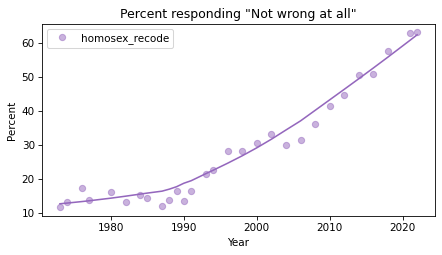

In [36]:
plot_series_lowess(percent_series, 'C4')

decorate(xlabel='Year',
         ylabel='Percent',
         title='Percent responding "Not wrong at all"')

The percentage of people who accept homosexuality was almost unchanged in the 1970s and 1980s, and began to increase quickly around 1990.
For a discussion of this trend, and similar trends related to racism and sexism, you might be interested in Chapter 11 of [Probably Overthinking It](https://probablyoverthinking.it).

## Discussion

Computing the mean of an ordinal variable can be a quick way to make comparisons between groups or show trends over time.
The computation implicitly assume that the points on the scale are equally spaced, which is not true in general, but in many cases it is probably good enough.

However, even when the mean (or standard deviation) is a reasonable choice, there is often an alternative that is easier to interpret in context.
It's always good to look at the distribution before choosing a summary statistic.
If it's bimodal, the mean is probably not the best choice.

*Data Q&A: Answering the real questions with Python*

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

## Appendix: Quantifying discord

We've seen that mean absolute deviation (MAD) can quantify the average level of disagreement between two people in a population.
As a generalization, it can also quantify the discord between two groups.

I might come back and expand this example later.

In [37]:
male = gss.query('sex == 1')
female = gss.query('sex == 2')

pmf_male = Pmf.from_seq(male['polviews'])
pmf_female = Pmf.from_seq(female['polviews'])

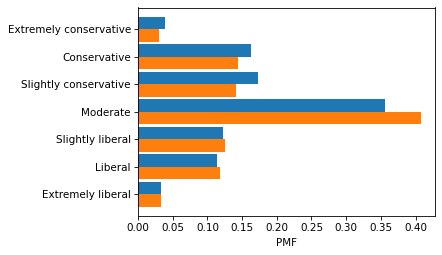

In [38]:
labels = list(polviews_dict.values())
plt.barh(labels, pmf_male, height=0.45, align='edge')
plt.barh(labels, pmf_female, height=-0.45, align='edge')
decorate(xlabel='PMF')

In [39]:
ps = np.outer(pmf_male, pmf_female)
qs = np.abs(np.subtract.outer(pmf_male.index, pmf_female.index))
np.sum(ps * qs)

1.5404976377345188

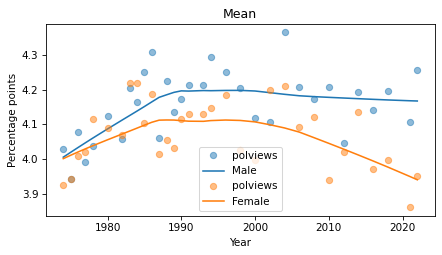

In [40]:
color_map = {1: 'C0', 2: 'C1'}
sex_dict = {1: 'Male', 2: 'Female'}

for name, group in gss.groupby('sex'):
    series_mean = group.groupby('year')['polviews'].mean()
    plot_series_lowess(series_mean, color_map[name], label=sex_dict[name])
    
decorate(xlabel='Year',
         ylabel='Percentage points',
         title='Mean')

In [41]:
def compute_diff(df):
    xtab = pd.crosstab(df['year'], df['polviews'], normalize='index')
    lib = xtab[[1, 2, 3]].sum(axis=1) * 100
    con = xtab[[5, 6, 7]].sum(axis=1) * 100
    return con - lib

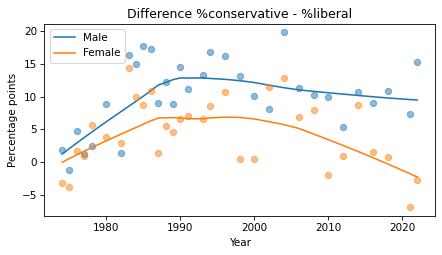

In [42]:
color_map = {1: 'C0', 2: 'C1'}
sex_dict = {1: 'Male', 2: 'Female'}

for name, group in gss.groupby('sex'):
    diff = compute_diff(group)
    plot_series_lowess(diff, color_map[name], label=sex_dict[name])
    
decorate(xlabel='Year',
         ylabel='Percentage points',
         title='Difference %conservative - %liberal')